# Introduction to Convolutional Neural Networks

## Prerequisites

* Neural Networks

* Supervised Learning - Classification Problems

## Learning Goals

* Build familiarity with the following concepts:

----

### Problems in Computer Vision

![](https://lisaong.github.io/mldds-courseware/03_TextImage/assets/image/cat_detectors.png)

![](https://hackernoon.com/hn-images/1*gVwu29o-uUukoz3b4qjTcA.png)

----

### Common Issues and "Quick" Fixes

#### Model Instability

![](https://miro.medium.com/max/573/1*Nj_toOwx_Hc5NLn97Jv-ww.png)

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQlGtmWtdoaxm7ewc1dKym91lpPo76qoRTh0pRZl88l3EXbRo92)

#### Data Augmentation

![](https://hackernoon.com/hn-images/1*Z8L-niHsUacRRKx2P7dhGg.png)

#### Test Time Augmentation

![](https://camo.githubusercontent.com/817c7a27705ee1ac0bbd6f5ebc4982f224d7a0b3/68747470733a2f2f707265766965772e6962622e636f2f6b48363176302f706970656c696e652e706e67)

#### Hardware

![](https://miro.medium.com/max/889/0*c0dbic0TZRh9ILrx.jpg)

----

### Transfer Learning

![](https://cdn-media-1.freecodecamp.org/images/1*BFIC_uZzi2v1p2254LLv2Q.png)

-----

## Example: MNIST (Hand-written Digit) Classifier w/ TensorFlow 

### Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import warnings
warnings.filterwarnings("ignore")

### Read Data

In [4]:
data = input_data.read_data_sets("./data/mnist", one_hot = True)

Extracting ./data/mnist\train-images-idx3-ubyte.gz
Extracting ./data/mnist\train-labels-idx1-ubyte.gz
Extracting ./data/mnist\t10k-images-idx3-ubyte.gz
Extracting ./data/mnist\t10k-labels-idx1-ubyte.gz


### Pixel Visualization

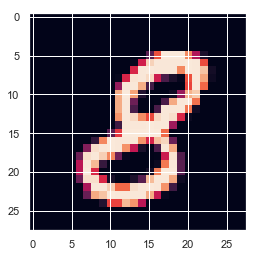

In [5]:
img = np.reshape(data.train.images[5], (28,28))
plt.imshow(img)

In [6]:
print("Max Value: {}\nMin Value: {}".format(np.max(img), np.min(img)))

Max Value: 1.0
Min Value: 0.0


### Setup

In [7]:
train_X = data.train.images.reshape(-1, 28, 28, 1)
test_X = data.test.images.reshape(-1, 28, 28, 1)
print("Train Shape: {}\nTest Shape: {}".format(train_X.shape, test_X.shape))

Train Shape: (55000, 28, 28, 1)
Test Shape: (10000, 28, 28, 1)


In [8]:
train_y = data.train.labels
test_y = data.test.labels

In [9]:
epochs = 10
learning_rate = 0.001
batch_size = 128

In [10]:
n_input = 28
n_classes = 10

In [11]:
x = tf.placeholder("float", [None, 28, 28, 1])
y = tf.placeholder("float", [None, n_classes])

### The Layers

In [12]:
def conv2d(x, W, b, stride = 1):
    x = tf.nn.conv2d(x, W, strides = [1, stride, stride, 1], padding = "SAME")
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k = 2):
    return tf.nn.max_pool(x, ksize = [1, k , k , 1], strides = [1, k , k, 1], padding = "SAME")

In [13]:
weights = {
    'wc1' : tf.get_variable('W0', shape = (3, 3, 1, 32), initializer = tf.contrib.layers.xavier_initializer()),
    'wc2' : tf.get_variable('W1', shape = (3, 3, 32, 64), initializer = tf.contrib.layers.xavier_initializer()),
    'wc3' : tf.get_variable('W2', shape = (3, 3, 64, 128), initializer = tf.contrib.layers.xavier_initializer()),
    'wd1' : tf.get_variable('W3', shape = (4 * 4 * 128, 128), initializer = tf.contrib.layers.xavier_initializer()),
    'out' : tf.get_variable('W4', shape = (128, n_classes), initializer = tf.contrib.layers.xavier_initializer())
}

biases = {
    'bc1': tf.get_variable('B0', shape = (32), initializer = tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape = (64), initializer = tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape = (128), initializer = tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape = (128), initializer = tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape = (10), initializer = tf.contrib.layers.xavier_initializer()),
}

### The Net

In [14]:
def conv_net(x, weights, biases):
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k = 2)
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k = 2)
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv3 = maxpool2d(conv3, k = 2)
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [19]:
pred = conv_net(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, 
                                                              labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [20]:
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
init = tf.global_variables_initializer()

### Training the Model

In [22]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(epochs):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")


        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.013913, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.97290
Iter 1, Loss= 0.010445, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98620
Iter 2, Loss= 0.008431, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98630
Iter 3, Loss= 0.004902, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98950
Iter 4, Loss= 0.012950, Training Accuracy= 0.99219
Optimization Finished!
Testing Accuracy: 0.98620
Iter 5, Loss= 0.011946, Training Accuracy= 0.99219
Optimization Finished!
Testing Accuracy: 0.98620
Iter 6, Loss= 0.001370, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98920
Iter 7, Loss= 0.000525, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98870
Iter 8, Loss= 0.000583, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98860
Iter 9, Loss= 0.000265, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.99000


### Model Performance

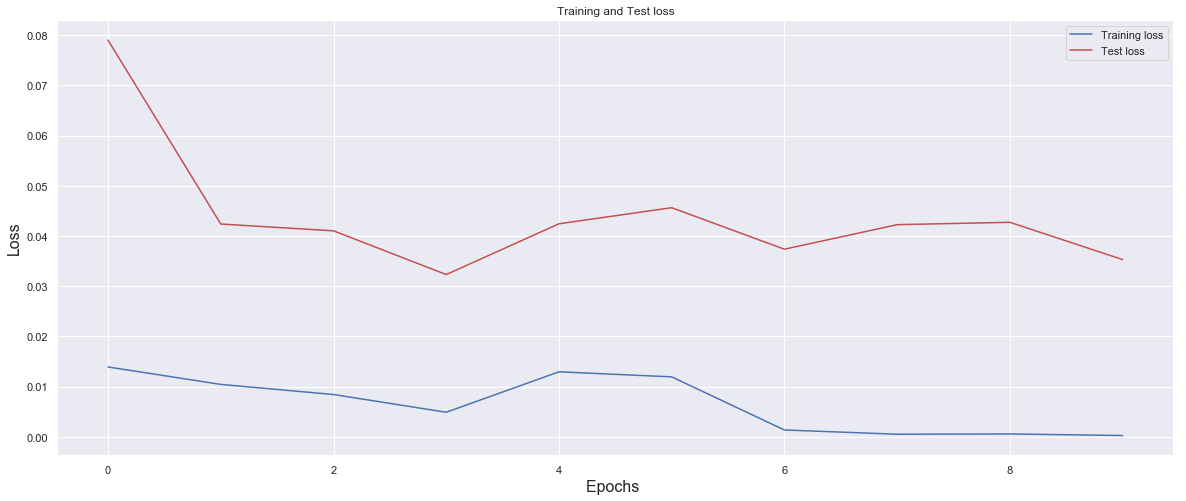

In [27]:
plt.figure(figsize=(20,8))
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

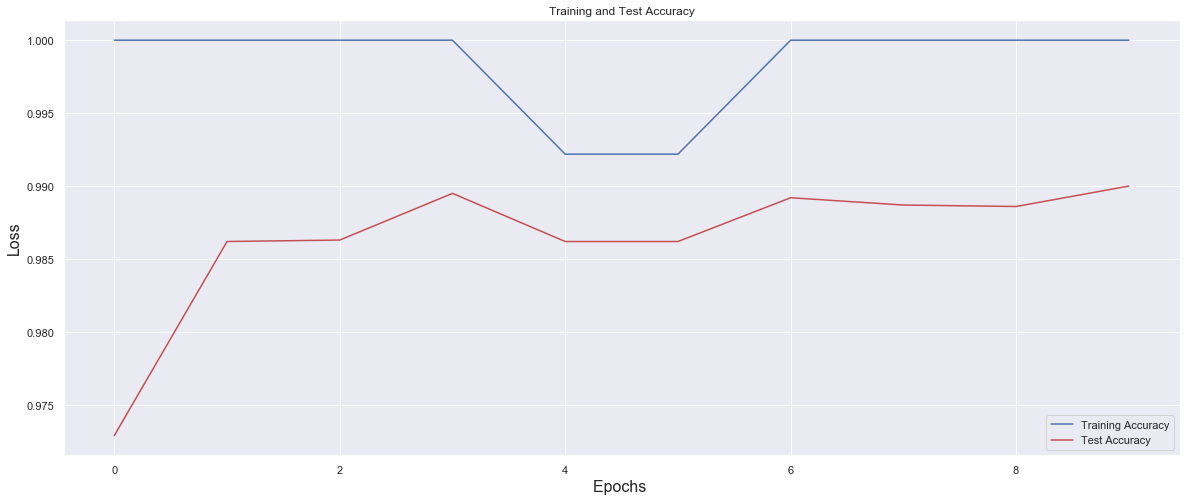

In [28]:
plt.figure(figsize=(20,8))
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

## How do CNNS work?

![](./CNN-Layers.png)

![](./CNN-Structural-Learning.png)

![](./CNN-Topology.png)

-----

# References / Resources

## Kaggle

* [A Very Comprehensive Tutorial to NNs and CNNs](https://www.kaggle.com/shivamb/a-very-comprehensive-tutorial-nn-cnn)

* [Flower Classification Competition **(w/ Free TPUs!)**](https://www.kaggle.com/c/flower-classification-with-tpus/overview/description)

* [Carvana Competition 1st Place Solution](https://github.com/asanakoy/kaggle_carvana_segmentation)

* [Carvana Competition 3rd Place Solution](https://github.com/lyakaap/Kaggle-Carvana-3rd-place-solution)

* [VGG16 + U-Net on Carvana](https://www.kaggle.com/kmader/vgg16-u-net-on-carvana)

* [Transfer Learning for Pneumonia](https://www.kaggle.com/mvwestendorp/transfer-learning-for-pneumonia)

## More on Segmentation

* [Image Segmentation - How to Turn Classifiers into Segmenters](https://meetshah1995.github.io/semantic-segmentation/deep-learning/pytorch/visdom/2017/06/01/semantic-segmentation-over-the-years.html)

* [Segmentation w/ TorchVision](https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)

* [Self-Driving Example: Segmentation w/ Pyramid Architecture](https://youtu.be/HYghTzmbv6Q)

* [MIT Scene Parsing Benchmark](http://sceneparsing.csail.mit.edu/)

* [YOLO Paper](https://arxiv.org/pdf/1506.02640.pdf)

## Papers

* [Bengio, *Practical Recommendations for Gradient-Based Training of Deep Architectures*](https://arxiv.org/pdf/1206.5533.pdf)

* [Hinton et al., *Improving NNs by preventing co-adaptation of feature detectors*](https://arxiv.org/pdf/1207.0580v1.pdf)

* [Hinton et al., *ImageNet Classification with Deep Convolutional Neural Networks*](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

* [LeCun et al., *Learning Convolutional Feature Hierarchies for Visual Recognition*](http://yann.lecun.com/exdb/publis/pdf/koray-nips-10.pdf)

* [Zeiler & Fergus, *Visualizing and Understanding Convolutional Networks*](https://www.matthewzeiler.com/mattzeiler/eccv2014.pdf)


## Stanford Lecture Series

* [Intro to CNNs for Visual Recognition](https://youtu.be/vT1JzLTH4G4)

* [Image Classification](https://youtu.be/OoUX-nOEjG0)

* [Loss Functions and Optimization](https://youtu.be/h7iBpEHGVNc)

* [Intro to NNs](https://youtu.be/d14TUNcbn1k)

* [CNNs](https://youtu.be/bNb2fEVKeEo)

* [Training NNs - Part I](https://youtu.be/wEoyxE0GP2M)

* [Training NNs - Part II](https://youtu.be/_JB0AO7QxSA)

* [Deep Learning Software](https://youtu.be/6SlgtELqOWc)

* [CNN Architectures](https://youtu.be/DAOcjicFr1Y)

## Implementations

* [Image Augmentation](https://github.com/andrewekhalel/edafa)

* [Text Augmentation](https://github.com/huggingface/transformers)

* [Keras Models](https://keras.io/applications/)

* [TensorFlow Models](https://github.com/tensorflow/models)

* [PyTorch Models](https://pytorch.org/docs/stable/torchvision/models.html)